In [1]:
import numpy as np
import matplotlib.pyplot as plt 

params = {'legend.fontsize': 18,
          'figure.figsize': (9, 6),
         'axes.labelsize': 24,
         'axes.titlesize':24,
         'axes.linewidth':3,
         'lines.linewidth':3,
         'xtick.labelsize':20,
         'ytick.labelsize':20}
plt.rcParams.update(params)
plt.style.use('seaborn-colorblind')
plt.rcParams['pdf.fonttype'] = 42

5.29 ms ± 254 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.87 ms ± 422 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
106 ms ± 3.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
87.1 ms ± 4.81 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
702 ms ± 33.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
408 ms ± 49.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.1 s ± 25.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
662 ms ± 36.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.58 s ± 10.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1e+03 ms ± 44.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.37 s ± 12.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.29 s ± 22.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.5 s ± 59.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.74 s ± 42.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.88 s ± 11.6 ms per loop (mean ± std.

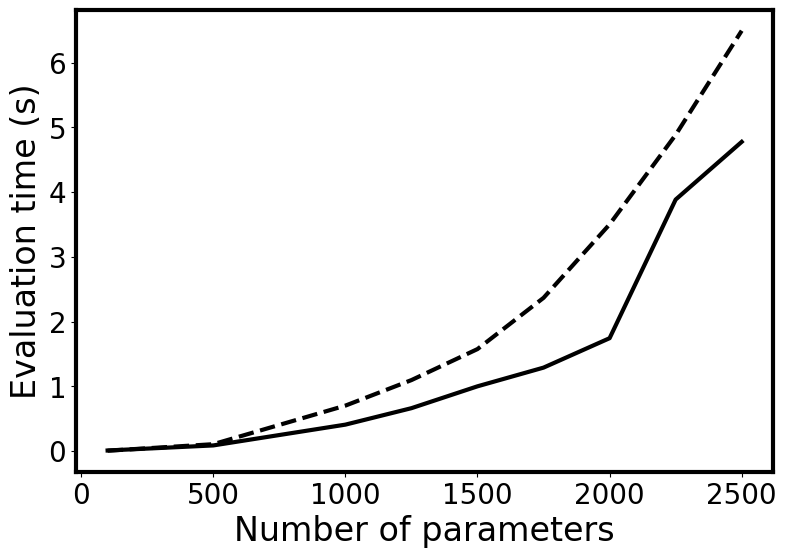

In [2]:
# number of samples in design
# n_samples = [1, 10, 100]
n_samples = [100]

# number of outputs
# n_outputs = [1, 10, 100]
n_outputs = [10]

# number of parameters
n_params = [100, 500, 1000, 1250, 1500, 1750, 2000, 2250, 2500]

# loop over number of points to sample
for n in n_samples:
    
    # loop over number of model outputs
    for n_out in n_outputs:

        # record eval times for each number of parameters
        eval_times_FIMB_mean = []
        eval_times_FIMB_stdv = []

        eval_times_FAST_mean = []
        eval_times_FAST_stdv = []
        
        # init output precision matrix
        B = np.eye(n_out)

        for n_p in n_params:
            # init prior precision matrix (symmetric positive definite matrix)
            A = np.random.randn(n_p, n_p)
            A = (A + A.T)/2. + n_p*np.eye(n_p)
            Ainv = np.linalg.inv(A)
            H0 = np.sum(np.log(np.linalg.eigvalsh(A)))

            def ln_det_FIMB(Gs):
                return np.sum(np.log(np.linalg.eigvalsh(A + sum([G.T@B@G for G in Gs])))) - H0

            def ln_det_FAST(Ai, Gs):
                ln_det = 0.
                for G in Gs[:-1]:
                    ln_det += np.sum(np.log(np.linalg.eigvalsh(np.eye(n_out) + B@G@Ai@G.T)))
                    GAi = G@Ai
                    Ai -= GAi.T@np.linalg.inv(B + GAi@G.T)@GAi       
                ln_det += np.sum(np.log(np.linalg.eigvalsh(np.eye(n_out) + B@Gs[-1]@Ai@Gs[-1].T)))

                return ln_det

            # generate random gradient matrices
            Gs = [np.random.randn(n_out, n_p) for _ in range(n)]

            # timeit -n 100 -r 10
            timeit_FIMB = %timeit -o ln_det_FIMB(Gs) 
            timeit_FAST = %timeit -o ln_det_FAST(np.copy(Ainv), Gs)

            # record results
            eval_times_FIMB_mean.append(timeit_FIMB.average)
            eval_times_FIMB_stdv.append(timeit_FIMB.stdev)

            eval_times_FAST_mean.append(timeit_FAST.average)
            eval_times_FAST_stdv.append(timeit_FAST.stdev)

        # convert lists to numpy arrays
        eval_times_FIMB_mean = np.array(eval_times_FIMB_mean)
        eval_times_FIMB_stdv = np.array(eval_times_FIMB_stdv)
        eval_times_FAST_mean = np.array(eval_times_FAST_mean)
        eval_times_FAST_stdv = np.array(eval_times_FAST_stdv)

        plt.plot(n_params, eval_times_FIMB_mean, c='k', label="FIMB", linestyle='--')
        '''plt.fill_between(n_params, 
                         eval_times_FIMB_mean-eval_times_FIMB_stdv, 
                         eval_times_FIMB_mean+eval_times_FIMB_stdv,
                         alpha=.7, color='C0')'''

        plt.plot(n_params, eval_times_FAST_mean, c='k', label="FAST")
        '''plt.fill_between(n_params, 
                         eval_times_FAST_mean-eval_times_FAST_stdv, 
                         eval_times_FAST_mean+eval_times_FAST_stdv,
                         alpha=.7, color='C1')'''

        plt.xlabel("Number of parameters")
        plt.ylabel("Evaluation time (s)")
        plt.savefig(f"n_out_{n_out}_n_sample_{n}.pdf", dpi=150)
        plt.show()